# k-최근접 이웃회귀의 한계
- 데이터 범위 밖의 새로운 데이터는 예측이 불가능

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import mglearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.datasets import load_breast_cancer, load_boston, load_diabetes
import warnings
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrix

warnings.simplefilter(action='ignore', category=FutureWarning)
# FutureWarning제거

%matplotlib inline

mpl.rcParams['font.family'] = 'D2coding'  # 한글 깨짐 해결

In [2]:
perch_length = np.array([8.4, 13.7, 15.0, 16.2, 17.4,
                         18.0, 18.7, 19.0, 19.6, 20.0,
                         21.0, 21.0, 21.0, 21.3, 22.0,
                         22.0, 22.0, 22.0, 22.0, 22.5,
                         22.5, 22.7, 23.0, 23.5, 24.0,
                         24.0, 24.6, 25.0, 25.6, 26.5,
                         27.3, 27.5, 27.5, 27.5, 28.0,
                         28.7, 30.0, 32.8, 34.5, 35.0,
                         36.5, 36.0, 37.0, 37.0, 39.0,
                         39.0, 39.0, 40.0, 40.0, 40.0,
                         40.0, 42.0, 43.0, 43.0, 43.5, 44.0])
perch_weight = np.array([5.9, 32.0, 40.0, 51.5, 70.0, 100.0,
                         78.0, 80.0, 85.0, 85.0, 110.0,
                         115.0, 125.0, 130.0, 120.0, 120.0,
                         130.0, 135.0, 110.0, 130.0, 150.0,
                         145.0, 150.0, 170.0, 225.0, 145.0,
                         188.0, 180.0, 197.0, 218.0, 300.0,
                         260.0, 265.0, 250.0, 250.0, 300.0,
                         320.0, 514.0, 556.0, 840.0, 685.0,
                         700.0, 700.0, 690.0, 900.0, 650.0,
                         820.0, 850.0, 900.0, 1015.0, 820.0,
                         1100.0, 1000.0, 1100.0, 1000.0, 1000.0])

In [3]:
train_input, test_input, train_target, test_target = train_test_split(
    perch_length, perch_weight, random_state=42
)

In [4]:
train_input = train_input.reshape(-1, 1)
test_input = test_input.reshape(-1, 1)

In [5]:
# k = 3 변경
knr = KNeighborsRegressor(n_neighbors=3)
knr.fit(train_input, train_target)

KNeighborsRegressor(n_neighbors=3)

In [6]:
# 길이가 50cm인 생선의 무게 예측
knr.predict([[50]])

array([1033.33333333])

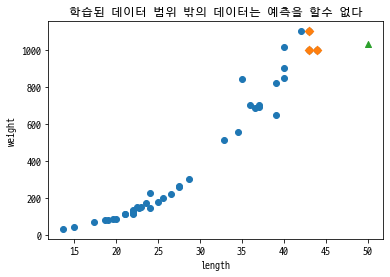

In [7]:
# 길이가 50cm인 생선의 주변 이웃
distances, indexs = knr.kneighbors([[50]])
plt.scatter(train_input, train_target)
plt.scatter(train_input[indexs],train_target[indexs], marker='D')
plt.scatter(50, 1033, marker='^')

plt.title('학습된 데이터 범위 밖의 데이터는 예측을 할수 없다')
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

In [8]:
# Linear Regression 알고리즘
lr = LinearRegression()
lr.fit(train_input, train_target)

LinearRegression()

In [9]:
lr.predict([[50]])

array([1241.83860323])

In [10]:
print(lr.coef_, lr.intercept_)

[39.01714496] -709.0186449535477


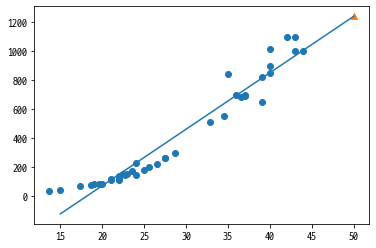

In [11]:
plt.scatter(train_input, train_target)

# 15 ~ 50
plt.plot([15, 50], [15*lr.coef_+lr.intercept_, 50*lr.coef_+lr.intercept_])

plt.scatter(50, 1241.8, marker='^')
plt.show()

In [12]:
print(lr.score(train_input, train_target))
print(lr.score(test_input, test_target))

0.939846333997604
0.8247503123313558


## 다항회귀

In [13]:
# 2차 방정식 그래프를 그리기 위해 길이를 제곱한 항을 추가
train_poly = np.column_stack((train_input ** 2, train_input))
test_poly = np.column_stack((test_input **2, test_input))

In [14]:
print(train_poly.shape, test_poly.shape)

(42, 2) (14, 2)


In [15]:
lr = LinearRegression()
lr.fit(train_poly, train_target)

LinearRegression()

In [16]:
print(lr.predict([[50**2, 50]]))

[1573.98423528]


In [17]:
# coef : 기울기, intercept : 절편
print(lr.coef_, lr.intercept_)

[  1.01433211 -21.55792498] 116.05021078278259


- 무게 = 1.01 * 길이^2 + -21.6 * 길이 + 116.05

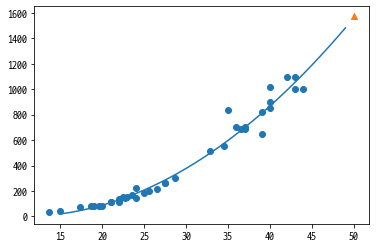

In [18]:
point = np.arange(15, 50)

plt.scatter(train_input, train_target)

plt.plot(point, 1.01*point**2 -21.6*point +116.05)
plt.scatter(50, 1574, marker='^')
plt.show()

In [19]:
print(lr.score(train_poly, train_target))
print(lr.score(test_poly, test_target))

0.9706807451768623
0.9775935108325121


# 특성공학과 규제

## 다중회귀(Multiple Regression)
- 여러 개의 특성을 사용한 선형 회귀 알고리즘
- 특성공학 : 기존의 특성을 사용해 새로운 특성을 뽑아내는 것

In [20]:
df = pd.read_csv('https://raw.githubusercontent.com/rickiepark/hg-mldl/master/perch_full.csv')

In [21]:
raw = df.to_numpy()

In [22]:
# 생선의 길이, 높이, 두께를 이용한 회귀분석
raw

array([[ 8.4 ,  2.11,  1.41],
       [13.7 ,  3.53,  2.  ],
       [15.  ,  3.82,  2.43],
       [16.2 ,  4.59,  2.63],
       [17.4 ,  4.59,  2.94],
       [18.  ,  5.22,  3.32],
       [18.7 ,  5.2 ,  3.12],
       [19.  ,  5.64,  3.05],
       [19.6 ,  5.14,  3.04],
       [20.  ,  5.08,  2.77],
       [21.  ,  5.69,  3.56],
       [21.  ,  5.92,  3.31],
       [21.  ,  5.69,  3.67],
       [21.3 ,  6.38,  3.53],
       [22.  ,  6.11,  3.41],
       [22.  ,  5.64,  3.52],
       [22.  ,  6.11,  3.52],
       [22.  ,  5.88,  3.52],
       [22.  ,  5.52,  4.  ],
       [22.5 ,  5.86,  3.62],
       [22.5 ,  6.79,  3.62],
       [22.7 ,  5.95,  3.63],
       [23.  ,  5.22,  3.63],
       [23.5 ,  6.28,  3.72],
       [24.  ,  7.29,  3.72],
       [24.  ,  6.38,  3.82],
       [24.6 ,  6.73,  4.17],
       [25.  ,  6.44,  3.68],
       [25.6 ,  6.56,  4.24],
       [26.5 ,  7.17,  4.14],
       [27.3 ,  8.32,  5.14],
       [27.5 ,  7.17,  4.34],
       [27.5 ,  7.05,  4.34],
       [27

In [23]:
weight = np.array([5.9, 32.0, 40.0, 51.5, 70.0, 100.0, 78.0, 80.0, 85.0, 85.0, 110.0,
       115.0, 125.0, 130.0, 120.0, 120.0, 130.0, 135.0, 110.0, 130.0,
       150.0, 145.0, 150.0, 170.0, 225.0, 145.0, 188.0, 180.0, 197.0,
       218.0, 300.0, 260.0, 265.0, 250.0, 250.0, 300.0, 320.0, 514.0,
       556.0, 840.0, 685.0, 700.0, 700.0, 690.0, 900.0, 650.0, 820.0,
       850.0, 900.0, 1015.0, 820.0, 1100.0, 1000.0, 1100.0, 1000.0, 1000.0])

## 데이터 분리

In [24]:
train_input, test_input, train_target, test_target = train_test_split(
    raw, weight, random_state=42
)

### 사이킷런 변환기

In [25]:
# 다항식 변환기
# from sklearn.preprocessing import PolynomialFeatures
# PolynomialFeatures : 현재 데이터를 다항식의 형태로 변경하는 역할

- 무게 = a*길이 + b*높이 + c*두께 + 1

In [26]:
poly = PolynomialFeatures(include_bias=False)
poly.fit(train_input)
train_poly = poly.transform(train_input)
# 컬럼명 추출
poly.get_feature_names()
test_poly = poly.transform(test_input)

### 다중 회귀 모델

In [27]:
# from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_poly, train_target)

LinearRegression()

In [28]:
lr.score(train_poly, train_target)

0.9903183436982125

In [29]:
lr.score(test_poly, test_target)

0.9714559911594155

In [30]:
poly = PolynomialFeatures(degree=5, include_bias=False)
poly.fit(train_input)
train_poly = poly.transform(train_input)
test_poly = poly.transform(test_input)
train_poly.shape

(42, 55)

In [31]:
lr.fit(train_poly, train_target)
lr.score(train_poly, train_target)
lr.score(test_poly, test_target)

-144.40744532797535

### 규제
- ML 모델이 과대적합되지 않도록 만드는 것
- 선형 회귀 모델의 경우 특성에 곱해지는 계수(기울기)의 크기를 작게 만드는 일

In [32]:
# from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_poly)
train_scaled = ss.transform(train_poly)
test_scaled = ss.transform(test_poly)

## 릿지 회귀 : ridge regression

In [33]:
# from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(train_scaled, train_target)
print(ridge.score(train_scaled, train_target))

0.9896101671037343


In [34]:
ridge.score(test_scaled, test_target)

0.9790693977615386

- 릿지 회귀(Ridge Regression) 모델 : 계수를 제곱한 값을 기준으로 규제 적용
- 라쏘 회귀(Lasso Regression) 모델 : 계수의 절대값을 기준으로 규제 적용
- 두 알고리즘 모두 계수의 크기를 줄이지만 라소는 아예 0으로 만들 수 있어서 릿지를 더 선호
- alpha : 릿지와 라쏘 모델을 사용할 때 규제의 양을 임의로 조절하는 하이퍼파라미터
- alpha 값이 크면 규제강도가 세지므로 계수값을 더 줄이고 조금 더 과소적합되도록 유도한다.
- alpha 값이 작으면 계수를 줄이는 역할이 줄어들고 선형 회귀모델과 유사해지므로 과대적합될 가능성이 크다.
- 하이퍼파라미터(Hyperparameter) : ML 모델이 학습할 수 없고 사람이 알려줘야 하는 파라미터

In [35]:
# 훈련세트와 테스트세트의 점수가 가장 가까운 지점이 최적의 alpha값이 된다.
train_score = []
test_score = []

alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]

for alpha in alpha_list:
    # ridge model
    ridge = Ridge(alpha=alpha)
    # ridge model
    ridge.fit(train_scaled, train_target)
    # R^2 score(결정계수)
    train_score.append(ridge.score(train_scaled, train_target))
    test_score.append(ridge.score(test_scaled, test_target))

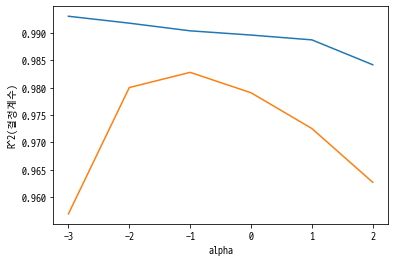

In [36]:
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('R^2(결정계수)')
plt.show()
# 최적 alpha값은 0.1

In [37]:
ridge = Ridge(alpha=0.1)
ridge.fit(train_scaled, train_target)
print(ridge.score(train_scaled, train_target))
print(ridge.score(test_scaled, test_target))

0.9903815817570368
0.9827976465386896


## 라쏘 회귀 : lasso Regression

In [38]:
# import Lasso
lasso = Lasso()
lasso.fit(train_scaled, train_target)
print(lasso.score(train_scaled, train_target))
print(lasso.score(test_scaled, test_target))

0.989789897208096
0.9800593698421884


In [39]:
# 훈련세트와 테스트세트의 점수가 가장 가까운 지점이 최적의 alpha값이 된다.
train_score = []
test_score = []

alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]

for alpha in alpha_list:
    # lasso model
    lasso = Lasso(alpha=alpha)
    # lasso model
    lasso.fit(train_scaled, train_target)
    # R^2 score(결정계수)
    train_score.append(lasso.score(train_scaled, train_target))
    test_score.append(lasso.score(test_scaled, test_target))

C:\Ananconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23364.075969939724, tolerance: 518.2793833333334
  model = cd_fast.enet_coordinate_descent(
C:\Ananconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20251.975097475362, tolerance: 518.2793833333334
  model = cd_fast.enet_coordinate_descent(
C:\Ananconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 806.2370926335934, tolerance: 518.2793833333334
  model = cd_fast.enet_coordinate_descent(


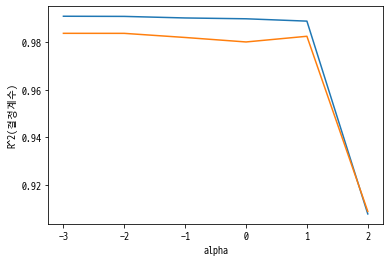

In [40]:
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('R^2(결정계수)')
plt.show()
# 최적 alpha값은 10

In [41]:
# import Lasso
lasso = Lasso(alpha=10)
lasso.fit(train_scaled, train_target)
print(lasso.score(train_scaled, train_target))
print(lasso.score(test_scaled, test_target))

0.9888067471131867
0.9824470598706695


In [42]:
np.sum(lasso.coef_ == 0)

40

# 실습문제 : 보스턴 집값 예측

In [43]:
boston = load_boston()
dir(boston)

['DESCR', 'data', 'feature_names', 'filename', 'target']

In [44]:
boston.data.shape

(506, 13)

In [45]:
boston.target.shape

(506,)

In [46]:
bos_df = pd.DataFrame(boston.data, columns=boston.feature_names)

In [47]:
bos_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [48]:
MEDV_df = pd.DataFrame(boston.target, columns=['MEDV'])

In [49]:
MEDV_df

,MEDV
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2
...,...
501,22.4
502,20.6
503,23.9
504,22.0


In [50]:
df = pd.concat([bos_df, MEDV_df], axis=1)
df.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


In [51]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [52]:
scaler = MinMaxScaler()

df_scaled = df.iloc[:, :-1]  # 마지막열임을 나타내는 -1은 포함하지 않음
scaler.fit(df_scaled)
df_scaled = scaler.transform(df_scaled)

# 스케일링 변환된 값을 데이터프레임에 반영
df.iloc[:, :-1] = df_scaled[:, :]
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.000000,0.18,0.067815,0.0,0.314815,0.577505,0.641607,0.269203,0.000000,0.208015,0.287234,1.000000,0.089680,24.0
1,0.000236,0.00,0.242302,0.0,0.172840,0.547998,0.782698,0.348962,0.043478,0.104962,0.553191,1.000000,0.204470,21.6
2,0.000236,0.00,0.242302,0.0,0.172840,0.694386,0.599382,0.348962,0.043478,0.104962,0.553191,0.989737,0.063466,34.7
3,0.000293,0.00,0.063050,0.0,0.150206,0.658555,0.441813,0.448545,0.086957,0.066794,0.648936,0.994276,0.033389,33.4
4,0.000705,0.00,0.063050,0.0,0.150206,0.687105,0.528321,0.448545,0.086957,0.066794,0.648936,1.000000,0.099338,36.2


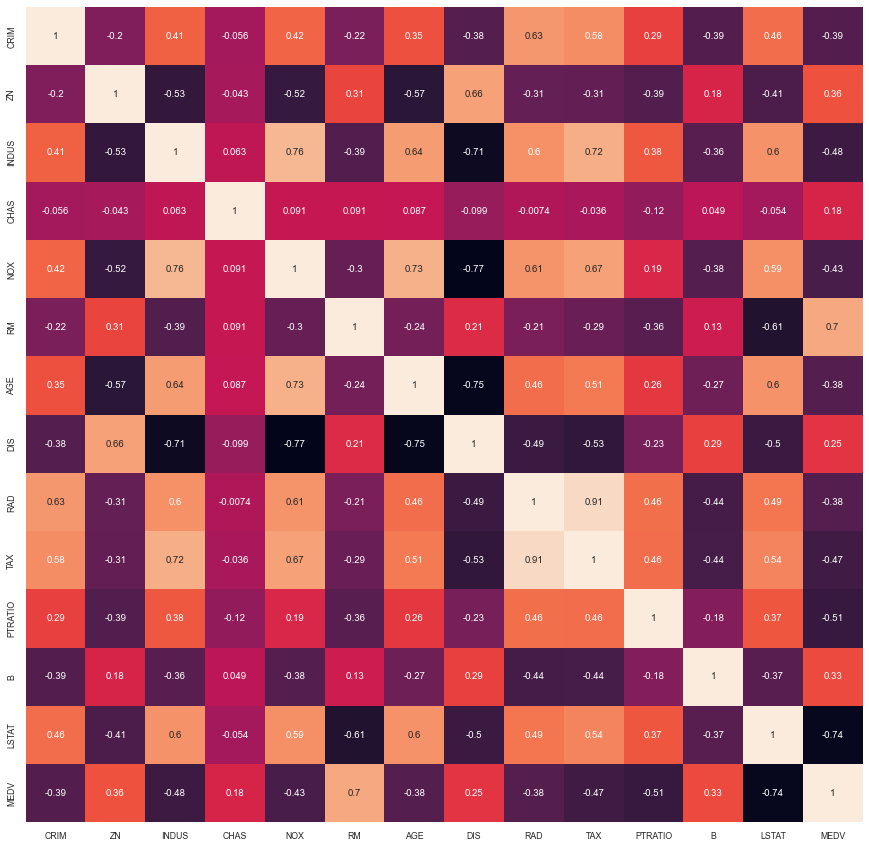

In [68]:
# 상관 관계 행렬(VIF 예측 가능)
df_corr = df.corr()

# 히트맵
plt.figure(figsize=(15, 15))
sns.set(font_scale=0.8)
sns.heatmap(df_corr, annot=True, cbar=False)
plt.show()

In [54]:
# 학습데이터와 테스트데이터 분할
X_train, X_test, y_train, y_test = train_test_split(df[['LSTAT', 'RM', 'PTRATIO', 'INDUS', 'TAX']],
                                                    df.iloc[:, -1],
                                                    random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(379, 5) (379,)
(127, 5) (127,)


In [55]:
# 상관계수가 높은 순으로 정렬해서 출력
order = df.corr().loc[:'LSTAT', 'MEDV'].abs().sort_values(ascending=False)
order

LSTAT      0.737663
RM         0.695360
PTRATIO    0.507787
INDUS      0.483725
TAX        0.468536
NOX        0.427321
CRIM       0.388305
RAD        0.381626
AGE        0.376955
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
Name: MEDV, dtype: float64

In [70]:
TEST = pd.DataFrame(boston.data, columns=boston.feature_names)

formula = 'scale(CRIM) + scale(ZN) + scale(INDUS) + scale(CHAS) + scale(NOX) + scale(RM) + scale(AGE) + scale(DIS) + scale(RAD) +\
scale(TAX) + scale(PTRATIO) + scale(B) + scale(LSTAT)'
dfx = dmatrix(formula, TEST, return_type='dataframe')
dfy = pd.DataFrame(boston.target, columns=['MEDV'])
vif = pd.DataFrame()

vif['VIF_Factor'] = [variance_inflation_factor(dfx.values, i) for i in range(dfx.shape[1])]
vif['Feature'] = dfx.columns
vif.sort_values(by='VIF_Factor', ascending=True).reset_index(drop=True)
vif

,VIF_Factor,Feature
0,1.000000,Intercept
1,1.792192,scale(CRIM)
2,2.298758,scale(ZN)
3,3.991596,scale(INDUS)
4,1.073995,scale(CHAS)
5,4.393720,scale(NOX)
6,1.933744,scale(RM)
7,3.100826,scale(AGE)
8,3.955945,scale(DIS)
9,7.484496,scale(RAD)


In [57]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [58]:
# 상관계수가 높은 열 추출
plot_cols = ['LSTAT', 'RM', 'PTRATIO', 'INDUS', 'TAX', 'MEDV']
plot_df = df.loc[:, plot_cols]
plot_df.head()

,LSTAT,RM,PTRATIO,INDUS,TAX,MEDV
0,0.089680,0.577505,0.287234,0.067815,0.208015,24.0
1,0.204470,0.547998,0.553191,0.242302,0.104962,21.6
2,0.063466,0.694386,0.553191,0.242302,0.104962,34.7
3,0.033389,0.658555,0.648936,0.063050,0.066794,33.4
4,0.099338,0.687105,0.648936,0.063050,0.066794,36.2


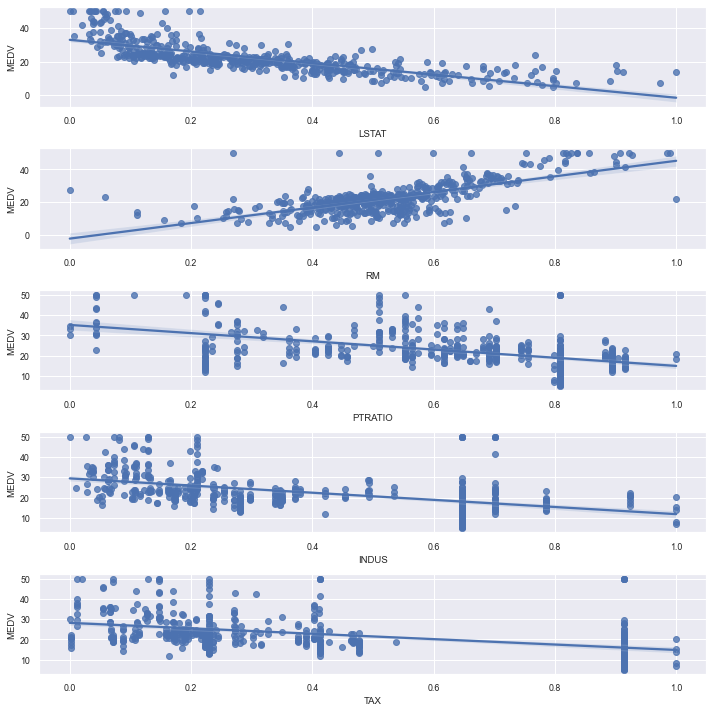

In [59]:
# 그래프로 연관성 확인
plt.figure(figsize=(10, 10))
for idx, col in enumerate(plot_cols[:-1]):
    ax1 = plt.subplot(5, 1, idx+1)
    sns.regplot(x=col, y=plot_cols[-1], data=plot_df, ax=ax1)
plt.tight_layout()
plt.show()

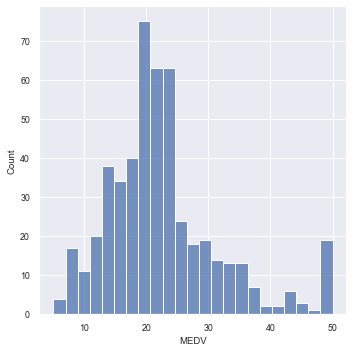

In [60]:
sns.displot(x='MEDV', kind='hist', data=df)
plt.show()

In [61]:
poly = PolynomialFeatures(include_bias=False)
poly.fit(X_train)
train_poly = poly.transform(X_train)
# 컬럼명 추출
print(poly.get_feature_names())
test_poly = poly.transform(X_test)

['x0', 'x1', 'x2', 'x3', 'x4', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x2^2', 'x2 x3', 'x2 x4', 'x3^2', 'x3 x4', 'x4^2']


In [62]:
# 선형 회귀 모형
lr = LinearRegression()
lr.fit(train_poly, y_train)

print("회귀계수(기울기):", np.round(lr.coef_, 1))  # np: numpy, coef_: 피처에 대한 회귀 계수 값
print("상수항(절편):", np.round(lr.intercept_, 1))  # intercept_: 상수항(절편) 값

회귀계수(기울기): [-26.8  52.1  17.5  16.1   8.7  49.   -3.3  -1.3 -19.4 -45.6  11.7 -31.3
 -10.6 -41.5  -8.5 -12.8  30.4   4.1   5.9   0.6]
상수항(절편): -0.1


In [72]:
# 성능 평가
y_train_pred = lr.predict(train_poly)
y_test_pred = lr.predict(test_poly)

train_mse = mean_squared_error(y_train, y_train_pred) #훈련 데이터의 평가 점수

print("Train MSE : %.4f" % train_mse)
print('Train RMSE : %.4f' % np.sqrt(train_mse))
print('Train score : %.4f' % lr.score(train_poly, y_train))

test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE : %.4f" % test_mse)
print('Test RMSE : %.4f' % np.sqrt(test_mse))
print('Test score : %.4f' % lr.score(test_poly, y_test))

Train MSE : 12.0690
Train RMSE : 3.4741
Train score : 0.8639
Test MSE : 15.9664
Test RMSE : 3.9958
Test score : 0.7720


C:\Ananconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Ananconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Ananconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Ananconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Ananconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Ananconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Ananconda3\lib\si

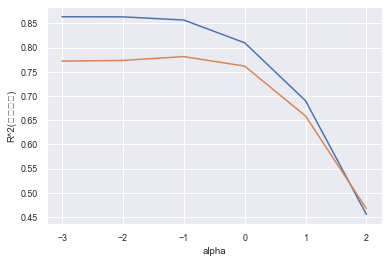

In [74]:
# 훈련세트와 테스트세트의 점수가 가장 가까운 지점이 최적의 alpha값이 된다.
train_score = []
test_score = []

alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]

for alpha in alpha_list:
    # ridge model
    ridge = Ridge(alpha=alpha)
    # ridge model
    ridge.fit(train_poly, y_train)
    # R^2 score(결정계수)
    train_score.append(ridge.score(train_poly, y_train))
    test_score.append(ridge.score(test_poly, y_test))

plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('R^2(결정계수)')
plt.show()
# alpha -1, 0

In [65]:
ridge = Ridge(alpha=0.1)
ridge.fit(train_poly, y_train)
print(ridge.score(train_poly, y_train))
print(ridge.score(test_poly, y_test))

0.8570972004324747
0.7815129923699176


In [66]:
# 훈련세트와 테스트세트의 점수가 가장 가까운 지점이 최적의 alpha값이 된다.
train_score = []
test_score = []

lasso = Lasso()

alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]
for alpha in alpha_list:
    # lasso model
    lasso = Lasso(alpha=alpha)
    # lasso model
    lasso.fit(train_poly, y_train)
    # R^2 score(결정계수)
    train_score.append(lasso.score(train_poly, y_train))
    test_score.append(lasso.score(test_poly, y_test))

C:\Ananconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.399711205509448, tolerance: 3.361037625329815
  model = cd_fast.enet_coordinate_descent(


C:\Ananconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Ananconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Ananconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Ananconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Ananconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Ananconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Ananconda3\lib\si

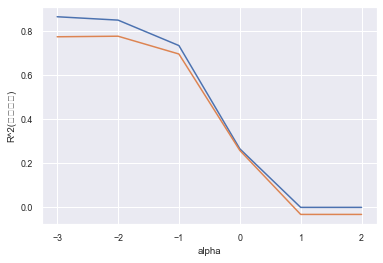

In [67]:
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('R^2(결정계수)')
plt.show()

In [75]:
lasso = Lasso(alpha=0.01)
lasso.fit(train_poly, y_train)
print(lasso.score(train_poly, y_train))
print(lasso.score(test_poly, y_test))

0.8482761312258675
0.775369853731808


In [ ]:
# 추가

# 실습문제 : 당뇨병 진행도 예측

In [ ]:
diabetes = load_diabetes()
dir(diabetes)